In [2]:
import pandas as pd
import pickle
import numpy as np
import datetime 
from os.path import join as pjoin
import os
import wrds

In [6]:
tmp_data_path = '../MA_data/data/tmp'

s_year = 1997
e_year = 2019

# Helper func


[A simple python program to automate the SQL query building for Wharton’s WRDS](https://imagoodboy.com/post/wrds_helper/)

In [31]:
from helpers import plot_missing, build_query

# Q1 WRDS and EVANS Mapping, which one is more trustworthy?

Q: if either side of the participants of a MA deal is a private firm (Either target or acquiror or both). How could `Evans_bridge` get the `GVKEY` info?
- Does it use the parents' `GVKEY` as the substitution of participants' `GVKEY`?


for anwsering this question, I created a new var named `GVS_t` and `GVS_a` (representing GVKEY source for both taregt and Acquiror); its value is:
    
| wrds found? | evans found? | 2 bridge match? | value (str) |
|-------------|--------------|-----------------|-------|
| 1           | 1            | 1               | 1     |
| 1           | 1            | 0               | 2     |
| 0           | 1            | 0               | 3     |
| 1           | 0            | 0               | 4     |
| 0           | 0            | 1               | 0     |


In [9]:
# load ori merged data

if os.path.isfile(pjoin(tmp_data_path , f'merged_ori_{s_year}_{e_year}.pickle')):
    merged_raw = pd.read_pickle(pjoin(tmp_data_path , f'merged_ori_{s_year}_{e_year}.pickle'))


In [10]:
merged_raw = merged_raw.reset_index(drop=True) 

Some notes:
1.  always use `pd.notna` and `pd.isna` to judge! do not use `== np.nan` or `==np.NaN`
2. `~pd.notna` is not equal to `pd.isna`


In [11]:

def bridge_explore(row, **kwargs):
    tmp_dict = {'t':'x', 'a':'y'}
    if pd.notna(row['GVKEY_'+ tmp_dict[F]]) & pd.notna(row[F+'gvkey']): # both found
        if row['GVKEY_'+ tmp_dict[F]] == row[F+'gvkey']:
            return '1'
        else:
            return '2'
    elif pd.isna(row['GVKEY_'+ tmp_dict[F]]) & pd.isna(row[F+'gvkey']): # both not found
        return '0'
    else:
        if pd.notna(row['GVKEY_'+ tmp_dict[F]]): # wrds found
            return '4'
        else:
            return '3'

In [12]:
for F in ['t', 'a']:
    merged_raw['GVS_'+F] = merged_raw.apply(bridge_explore, F=F, axis=1)

keep in mind we want to make sure there are 2 matches for every obs; one from wrds, one from evans.
- for evans_bridge, delete NAs (previously presented as `'-1'`)
- for wrds_bridge, make sure the match is lying under the "effective time period".



`anomaly_all`: both bridge found target gvkey, but gvkeys are not the same. (the `2` condition)


In [116]:
# extract anomaly for target
merged_raw_2_t = merged_raw[(merged_raw['tgvkey'] != '-1') & ((merged_raw['LINKDT_x'] <= merged_raw['DA']) & (merged_raw['LINKENDDT_x'] >= merged_raw['DA']))] 
anomaly_all_t = merged_raw_2_t[(merged_raw_2_t['GVS_t'] == '2') ][['TCU', 'TNL', 'TPUBC', 'TUP', 'TUPNAMES', 'TUPPUB', 'GVKEY_x','tgvkey', 'DEAL_NO']]


In [117]:
# extract anomaly for acquiror

merged_raw_2_a = merged_raw[(merged_raw['agvkey'] != '-1') & ((merged_raw['LINKDT_y'] <= merged_raw['DA']) & (merged_raw['LINKENDDT_y'] >= merged_raw['DA']))] 
anomaly_all_a = merged_raw_2_a[(merged_raw_2_a['GVS_a'] == '2') ][['ACU', 'ANL', 'APUBC', 'AUP', 'AUPNAMES', 'AUPPUB', 'GVKEY_y','agvkey', 'DEAL_NO']]


we focus on 2

In [118]:
print('the table that wrds and evans bridge linkings give different target gvkey matchs : ', anomaly_all_t.shape, '\n')
print('the table that wrds and evans bridge linkings give different acquiror gvkey matchs : ', anomaly_all_a.shape)

the table that wrds and evans bridge linkings give different target gvkey matchs :  (74, 9) 

the table that wrds and evans bridge linkings give different acquiror gvkey matchs :  (224, 9)


In [119]:
print('GVS_a condition info:\n', merged_raw_2['GVS_a'].value_counts(),'\n')
print('GVS_t condition info:\n', merged_raw_2['GVS_t'].value_counts(),'\n')

GVS_a condition info:
 4    19288
0     3885
3     3686
1     3669
2      237
Name: GVS_a, dtype: int64 

GVS_t condition info:
 4    23173
1     7518
2       74
Name: GVS_t, dtype: int64 



`anomaly_notsame`: the cusip of the `target` and the `parent of the target` is different

`anomaly_same`: ~`anomaly_notsame`

In [120]:
# anomaly_notsame_t = anomaly_all_t[anomaly_all_t.TCU != anomaly_all_t.TUP]
# anomaly_notsame_a = anomaly_all_a[anomaly_all_a.ACU != anomaly_all_a.AUP]

In [121]:
# anomaly_same_t = anomaly_all_t[anomaly_all_t.TCU == anomaly_all_t.TUP]
# anomaly_same_a = anomaly_all_a[anomaly_all_a.ACU == anomaly_all_a.AUP]

In [122]:
# anomaly_notsame.to_csv('anomaly_notsame.csv')
# anomaly_same.to_csv('anomaly_same.csv')


## Case Study



### Case 1

target and ultimate parent are the same according to CUSIP

![](https://cdn.mathpix.com/snip/images/9eJ6mpO4DsBsTU3M_H8inTcUPz3jW3ozX385_HdxWJE.original.fullsize.png)

Both the WRDS match and EVANS match are wrong.

The Stober Organization Inc is a [private firm ](https://www.crunchbase.com/organization/the-strober-organization)



### Case 2

![](https://cdn.mathpix.com/snip/images/axFN-Q-QCzFwc8xtHUw7fsphNM-MKhbhcSItL6O7sMw.original.fullsize.png)

`Interactive Group` is also a private firm according to cruchbase

### by maunally check the firm names


I retreive the firm name `conm` via `GVKEY_x` and `tgvkey` (from wrds linking and evans linking) from compustat. 


In [72]:
db = wrds.Connection()
db = wrds.Connection(wrds_username='dayuyang1999')

Enter your WRDS username [dalab5]:dayuyang1999
Enter your password:········
WRDS recommends setting up a .pgpass file.
Create .pgpass file now [y/n]?: y
Created .pgpass file successfully.
Loading library list...
Done
Loading library list...
Done


In [123]:
def add_true_firmname(df, key):
    '''
    args:
        df: ori data df 
        key: string, var name contains gvkey
    return: df with a new var read_firm_name
    
    '''
    gvkeys = df[key].astype(str).to_list()
    columns = ['gvkey','conm']
    
    query = build_query(dataset = 'comp.funda',
                   columns = columns,
                   gvkey = gvkeys,
                   start = '1997-01-01',
                   end='2021-01-01')
    gvkey_tmp = db.raw_sql(query)
    gvkey_tmp.drop_duplicates(subset=['gvkey','conm'], keep='last')
    df2 = df.merge(gvkey_tmp, left_on = key, right_on = "gvkey", how = "left")
    df2 = df2.drop('gvkey', 1)
    df2 = df2.rename(columns={'conm':key+'compustat_firmname'})
    return df2
    
    

In [124]:
# match name for target anomaly
df_merged_t_1 = add_true_firmname(anomaly_all_t, 'GVKEY_x')
df_merged_t_2 = add_true_firmname(df_merged_t_1, 'tgvkey')
df_merged_t_2 = df_merged_t_2.drop_duplicates(subset=['TCU','TNL','TUP','TUPNAMES', 'GVKEY_xcompustat_firmname', 'tgvkeycompustat_firmname'], keep='last')


In [125]:
# match name for acquirer anomaly
df_merged_a_1 = add_true_firmname(anomaly_all_a, 'GVKEY_y')
df_merged_a_2 = add_true_firmname(df_merged_a_1, 'agvkey')
df_merged_a_2 = df_merged_a_2.drop_duplicates(subset=['ACU','ANL','AUP','AUPNAMES','GVKEY_ycompustat_firmname', 'agvkeycompustat_firmname'], keep='last')


In [126]:
print(df_merged_t_2.shape)
print(df_merged_a_2.shape)

(50, 11)
(58, 11)


In [127]:
df_merged_t_2.to_csv('check_q1_target.csv')
df_merged_a_2.to_csv('check_q1_acquiror.csv')

#### For target

manually check the csv file.
- why manually? 
    - since the name of firm is hard to match(should be pre-processed if check by code)

If there is: the firm name from compustat `GVKEY_xcompustat_firmname`	or `tgvkeycompustat_firmname`:
1. do not match to `TNL`, but match `TUPNAMES`
    - which means the linking use ultimate parent as substitution of original target
1. do not match to either `TNL` or `TUPNAMES`
    - which means the match is wrong



**findings**:

##### 1st

for condition 1 above, I do find 2 instances:

![](https://cdn.mathpix.com/snip/images/7wxItivAjSwPm3OWENrkHWT6C3409g2xpyaVhGFyarQ.original.fullsize.png)

- see deal `2722161020`, wrds linking gives us the gvkey of `GREAT WOLF RESORTS INC`, which is the correct target. However, evans linking gives us the gvkey of its ultimate parent which is `APOLLO GLOBAL MGMT INC`, this is wrong.

- see deal `2797838020`, again, wrds linking is correct.



##### 2nd

lots of obs lies on condition 2, that means both the wrds and evans linkings give us wrong gvkey matchs. So we cannot find info corresponding to those gvkeys in compustat database.

![](https://cdn.mathpix.com/snip/images/-OJdW04mtZReoPkQ9rxcfsRNNfiPEtkVx1CiAu_1nVQ.original.fullsize.png)


#### For acquiror

situation are similar to target, for example, see deal `1623900020`:

![](https://cdn.mathpix.com/snip/images/INiIuqw0sr7xaZWGal8CP5Sy1ThszPVetLBWWGHTxsQ.original.fullsize.png)



## Answer to Q1

1. we should trust WRDS linking more than EVANS linking
    - so if both give gvkey match, use the one from `wrds`
    - if only one gives, use that one (better than nothing)

2. sometimes, the WRDS or EVANS linking gives us wrong GVKEY matches
    - after retreving financial variables from Compustat (using the gvkey wrds or evans linking gives us), simply drop those NAs.

# Q2: at least one is Public, then analysisable



- Although `GVKEY` is mostly for public firm, but some private firm do have `GVKEY` as well.
- However, TNIC would only cover Public firms.

Which means, we could only analysis the following conditions:

| APUBC == Public? | AUPPUB == Public? | TPUBC == Public? | TUPPUB == Public? | mark as                                           |
|------------------|-------------------|------------------|-------------------|---------------------------------------------------|
| 1                | 1                 | 1                | 1                 | 1                                                 |
| 1                | 1                 | 1                | 0                 | 2                                                 |
| 1                | 1                 | 0                | 1                 | 3                                                 |
| 1                | 0                 | 1                | 1                 | 4                                                 |
| 1                | 0                 | 1                | 0                 | 5                                                 |
| 1                | 0                 | 0                | 1                 | 6                                                 |
| 0                | 1                 | 1                | 1                 | 7                                                 |
| 0                | 1                 | 1                | 0                 | 8                                                 |
| 0                | 1                 | 0                | 1                 | 9                                                 |
|                  |                   |                  |                   | all other combination is unanalysiable, mark as 0 |


We need to analysis the ratio first before deciding how to manipulate the model:


In [151]:
sdc_df = pd.read_pickle(pjoin(tmp_data_path , f'sdc_{s_year}_{e_year}.pickle'))

In [152]:
def mark_if_public(row, **kwargs):
    if (row.APUBC == 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB == 'Public'):
        return '1'
    elif (row.APUBC == 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB != 'Public'):
        return '2'
    elif (row.APUBC == 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC != 'Public') & (row.TUPPUB == 'Public'):
        return '3'
    elif (row.APUBC == 'Public') &  (row.AUPPUB != 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB == 'Public'):
        return '4'
    elif (row.APUBC == 'Public') &  (row.AUPPUB != 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB != 'Public'):
        return '5'
    elif (row.APUBC == 'Public') &  (row.AUPPUB != 'Public') & (row.TPUBC != 'Public') & (row.TUPPUB == 'Public'):
        return '6'
    elif (row.APUBC != 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB == 'Public'):
        return '7'
    elif (row.APUBC != 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC == 'Public') & (row.TUPPUB != 'Public'):
        return '8'
    elif (row.APUBC != 'Public') &  (row.AUPPUB == 'Public') & (row.TPUBC != 'Public') & (row.TUPPUB == 'Public'):
        return '9'
    else:
        return '0'

In [153]:
sdc_df['PUB_COND'] = sdc_df.apply(mark_if_public, axis=1)

In [154]:
print(sdc_df.PUB_COND.value_counts(), '\n', f'Ratios : \n {sdc_df.PUB_COND.value_counts()/sdc_df.shape[0]*100}')
#print(merged.PUB_COND.value_counts())

0    222921
1     27358
3     14550
9      5818
7      1141
5       482
6       404
4       249
2       189
8        38
Name: PUB_COND, dtype: int64 
 Ratios : 
 0    81.611203
1    10.015742
3     5.326744
9     2.129965
7     0.417719
5     0.176460
6     0.147904
4     0.091159
2     0.069193
8     0.013912
Name: PUB_COND, dtype: float64


So, mostly are 3, 1, 9, 0, 7.

## `3` and `9`
`3` : A public acquiror acquires a non-public firm but its parent firm is a public firm(..see table for better understanding).

We could see mostly are `Sub.`:

- `Subsidiary`: According to [investopedia](https://www.investopedia.com/terms/t/takeover.asp), After the 50% threshold has been breached, the target company should be considered a subsidiary.


So **I think(should find paper for endorcement)** `3` is a type of takeover that `ACU`(a Public firm) acquiror "a small portion of" the `TUP` (**Pay attention to the abrrev!**).

- Ok, I found the endorcement, see [Jaffe, Jeffrey, Jan Jindra, David Pedersen, and Torben Voetmann. "Returns to acquirers of public and subsidiary targets." Journal of Corporate Finance 31 (2015): 246-270.](https://reader.elsevier.com/reader/sd/pii/S0929119915000310?token=7DD9D17E9A100FD0A9EFE2E85EA5F6AE17E572DE2A7D4488FF8AD400E526C366CA1D05ADBC7A123590D379757B64A6B7&originRegion=us-east-1&originCreation=20210911194358)

   

In [146]:

sdc_df[(sdc_df.APUBC == 'Public') &  (sdc_df.AUPPUB == 'Public') & (sdc_df.TPUBC != 'Public') & (sdc_df.TUPPUB == 'Public')].TPUBC.value_counts()


Sub.     6957
J.V.      157
Priv.      92
Govt.       2
Name: TPUBC, dtype: int64

In [148]:
merged[(sdc_df.APUBC != 'Public') &  (sdc_df.AUPPUB == 'Public') & (sdc_df.TPUBC != 'Public') & (sdc_df.TUPPUB == 'Public')].TPUBC.value_counts()


Sub.     2151
J.V.       42
Priv.      14
Govt.       2
Name: TPUBC, dtype: int64

## `1` and `7`

`1`: Just Normal Condition, no need to worry about

# Q3 Only Consider Complete?

Observations:
1. So far, all MA quantitiative analysis research I read only consider complete transactions...
2. Withdrawn bid may be valuable to cindiser...

Definition:



In [149]:
merged_public = pd.read_pickle(pjoin(tmp_data_path , f'merged_public_{s_year}_{e_year}.pickle'))

In [150]:
merged_public.STATC.value_counts()

C     13893
P      1161
W      1039
UN      415
DR       88
I        45
R         5
IW        2
PC        1
Name: STATC, dtype: int64

# Q4 which variable are good to define "majority" takeover

In [7]:
sdc_df = pd.read_pickle(pjoin(tmp_data_path , f'sdc_{s_year}_{e_year}.pickle'))

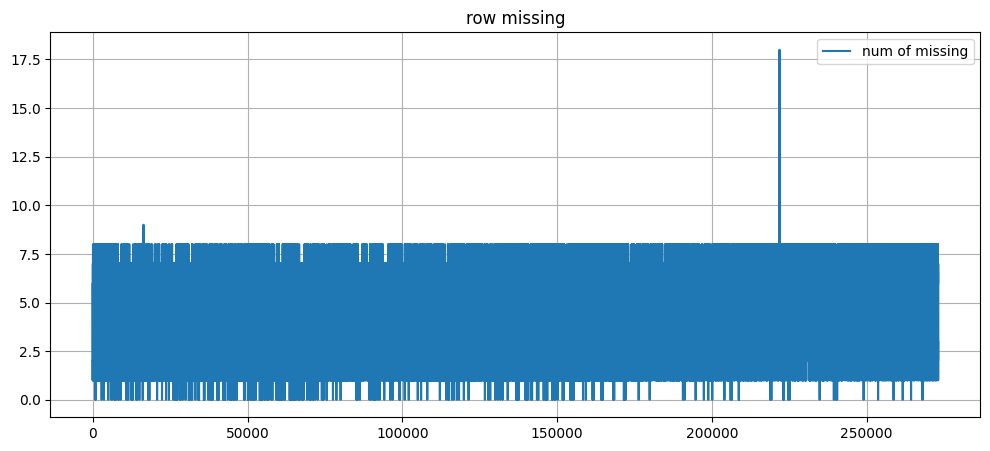

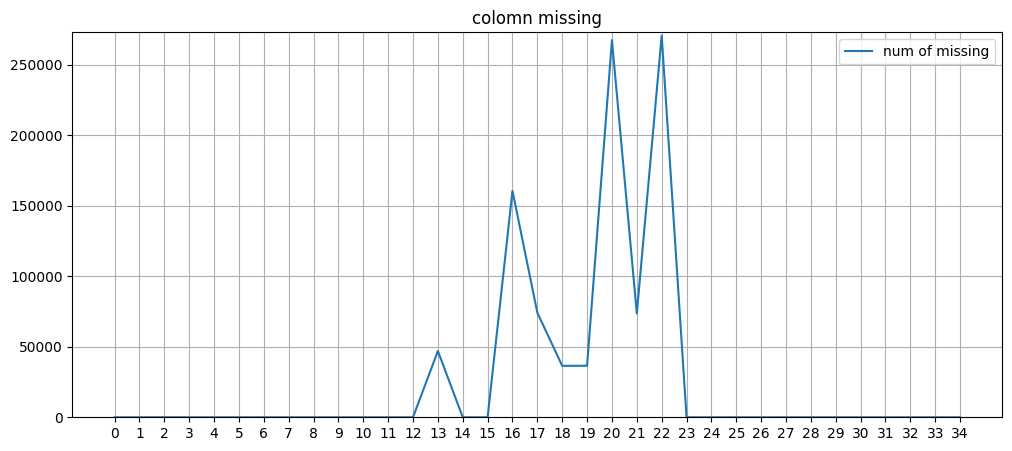

variable missing percentage : 
 ACU               0.000000
ASIC2             0.000000
ABL               0.010617
ANL               0.000000
APUBC             0.000000
AUP               0.000366
AUPSIC            0.000366
AUPBL             0.002563
AUPNAMES          0.000366
AUPPUB            0.000366
BLOCK             0.000000
CREEP             0.000000
DA                0.000000
DE               17.216548
STATC             0.000000
SYNOP             0.000366
VAL              58.802123
PCTACQ           27.158338
PSOUGHTOWN       13.356764
PSOUGHT          13.383123
PHDA             97.952041
PCTOWN           26.963939
PSOUGHTT         99.122094
PRIVATIZATION     0.000000
DEAL_NO           0.000000
TCU               0.000000
TSIC2             0.000000
TBL               0.002563
TNL               0.000000
TPUBC             0.000000
TUP               0.000366
TUPSIC            0.000366
TUPBL             0.002563
TUPNAMES          0.000366
TUPPUB            0.000366
dtype: float64
variable

In [34]:
plot_missing(sdc_df)